# Initial guess algorithm in adiabatic quantum computing simulations
---

## Reading materials 
1. Quantum Optimization for Maximum Independent Set Using Rydberg Atom Arrays - Hannes Pichler
2. Lecture 32: Luby’s Algorithm for Maximal Independent Set - Gary Miller
3. A study of heuristic guesses for adiabatic quantum computation - Alejandro Perdomo-Ortiz

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
# The library for quantum adiabatic simulations.
from qutip import * 
from scipy import *
# The library used for the graph representation.  
import networkx as nx
from LubyAlgoHelper import *


## Researched Algorithes

In this notebook I will compare 3 different approaches to solve MIS (Maximum independent sets):

### Normal - The known algorithm using Rydbeg atoms

We simply use the algorithm that's described by Hannes Pichler:
$$\begin{cases}
H_0 = \sum_{n=1}^NI - \sigma_x^n \\
H_p = -\Delta n_v \\
H_{int} = \sum_{v<w}V/x^6(|\vec{x}_v-\vec{x}_w|)n_vn_w
\end{cases}
$$

Using that we can build a full hamiltonian:
$$H_{tot} = H_0 \Omega(t) + H_p\Delta(t) + H_{int}$$


### Heuristic Guess

As the name suggests we add a heuristic guesses for each vertex based on it's degree in the graph.

The new initial hamiltonian is as follows:
$$\tilde{H}_0 = \sum_{n=1}^{N}\left(x_n \hat{I}+ \hat{q}_n(1-2x_n)\right) + \delta\sum_{n=1}^{N}\sigma_x^n$$

With $x_n$ being the guess:

$$x_n=\begin{cases}
1\rangle & & \frac{1}{dv} \geq C\\ 
0 \rangle & & \frac{1}{dv} < C
\end{cases}$$

and $\hat{q}_n$ is  $$\hat{q}_n = \hat{I}_N \otimes\hat{I}_{N-1} \otimes \dots \otimes \frac{1}{2}(\hat{I}-\sigma_z^n)\otimes \dots \otimes I_1$$


Finally $dv$ is the degree of vertex v, and constant $C \in [0,1]$ defines which vertex is assumed to start at ground and which is assumed to start at Rydberg. 

**_NOTE:_** We don't want divergance in out initial guess, which will happen if two adjacent vertex are drawn to Rydberg. For step I, our way to solve this is to set $C=1$. Meaning that only if the vertex is a leaf, it will start at Rydberg. Of course no two leafs are adjacent so no divergance will accure. 

In fact we can prove easly that all leafs can always be in the MIS. 
Assuming that there is a leaf v and an MIS G that doesn't contain v, since $G \cup v$ is a bigger graph and isn't the MIS, the vertex k that's connected to v must be in G. We can create a new graph $G'$ which is the same as G but with v instead of k. That is clearly also an MIS of same size.

### Our algorithm

As Adi suggested, using an initial setup on $|\psi_0 \rangle$ could result in better complexity.
As a follow up from the Heuristic Guess we can set it up as follows:
 $$|\psi_0 \rangle=\begin{cases}
|r\rangle & & \frac{1}{dv} \geq C\\ 
|g \rangle & & \frac{1}{dv} < C
\end{cases}$$

However since the corrent Hamiltonian aspires for grounds states at the start, we need to change it.
The algorithm we decided to test is:

$$H'_{tot} = (1-s)\sum_{n=1}^{N} \Delta_0 \left(x_n \hat{I}+ \hat{q}_n(1-2x_n)\right) + \Omega(t)\delta\sum_{n=1}^{N}\sigma_x^n -s\Delta_0 n_v+H_{int}$$
---

## Parameters


### Defining usefull matrixs  

$$
\sigma_x = \begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix} , \sigma_y = \begin{pmatrix}
0 & -i \\
i & 0
\end{pmatrix} , \sigma_z = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
 , 
|0\rangle = \begin{pmatrix} 1 \\ 0 \end{pmatrix}
, |1\rangle  = \begin{pmatrix} 0 \\ 1 \end{pmatrix}
$$

In [18]:
# Pauli matrices and identity operator
si = qeye(2)
sx = sigmax()
sz = sigmaz()
zero = basis(2, 0)  # |1><1|
one = basis(2, 1)  # |1><1|

def generate_operators(N):
    """
    Generates useful quantum operators for a system of N qubits.

    Parameters:
    N (int): The number of qubits in the system.

    Returns:
    tuple: A tuple containing lists of tensor products of Pauli matrices and projectors.
           (sx_list, sz_list, one_list, I_N)
    """

    # Initialize empty lists for storing operators
    sx_list = []
    sz_list = []
    one_list = []

    # Identity tensor for N qubits
    I_N = tensor([si] * N)

    # Generate the operators
    for n in range(N):
        # Initialize a list of identities for the tensor product
        op_list = [si] * N

        # Replace the n-th position with sx, sz, or |1><1|
        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = 0.5 * (si - sz)
        sz_list.append(tensor(op_list))

        op_list[n] = one * one.dag()
        one_list.append(tensor(op_list))

    return sx_list, sz_list, one_list, I_N

# Later, you can use the graph to determine N
# Example usage:
# N = len(graph.nodes)
# sx_list, sz_list, one_list, I_N = generate_operators(N)

### Hamiltonian parameters

Using page 4 of the article, we know the detuning ($\Delta(t)$) ,rabi frequency ($\Omega(t)$) and the rabi blockade radius($r_B$). 
$$\Delta(t) = \Delta_0 (2t/T-1)  $$
 $$ \Omega(t) = \Omega_0 sin^2(\pi t/T)$$
$$r_B = \left(C/\sqrt{(2\Omega)^2+\Delta^2}\right)^{1/6}$$

Where C is the interuction strength of rydberg atoms. We also use $\Omega_0 = 1$ and $\Delta_0/\Omega_0 = 6$.

To get the scale of the required T to finish the adiabatic transformation, we can look at different finish times:  
$$T = 5/\Omega_0 , 10/\Omega_0 ,\dots$$

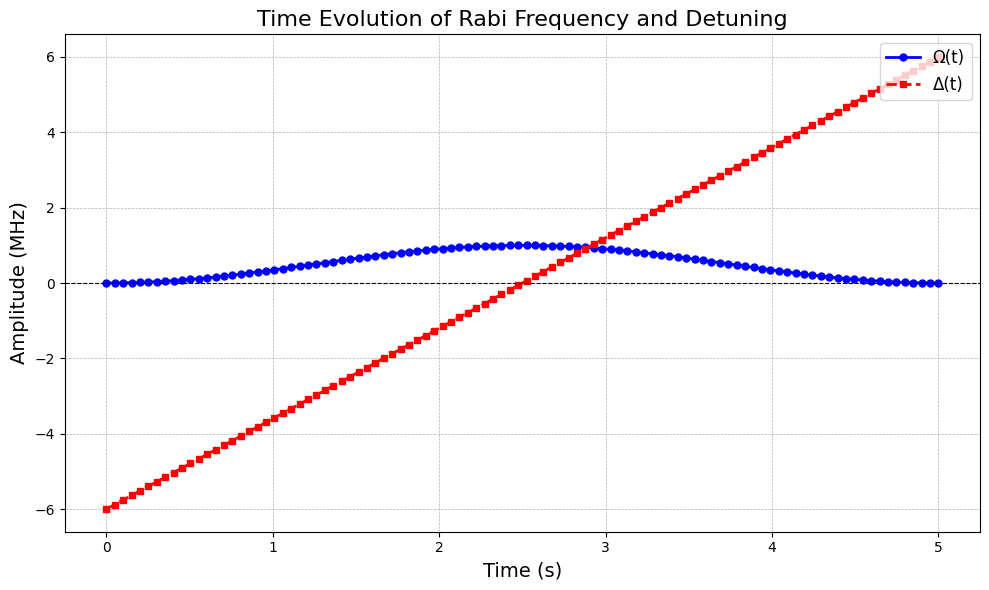

In [19]:
def initialize_system_parameters(delta=1.5, degree_min=1, omega_0 = 1, tau_max = 5):
    """
    Initializes the system parameters and returns the blockade radius, time-dependent 
    functions for Omega and Delta, and other constants.
    
    Parameters:
    delta (float): Power of driving Hamiltonian
    degree_min (float): Minimum degree threshold for the graph
    OMEGA_0 (float): Base Rabi frequency
    tau_max(float): in units of omega_0, the size of TAU_MAX
    
    Returns:
    dict: A dictionary containing time-dependent functions and system parameters
    """
    DELTA_0 = 6 / omega_0  # Initial detuning
    TAU_MAX = tau_max / omega_0  # Maximum time (in units of omega_0)
    INTERACTION_STRENGTH = 8.6 * omega_0  # Interaction strength constant

    # Calculate blockade radius
    blockade_radius = round((INTERACTION_STRENGTH * omega_0 / np.sqrt((2 * omega_0) ** 2 + DELTA_0 ** 2)) ** (1 / 6), 10)
    
    # Define time points for plotting
    taulist = np.linspace(0, TAU_MAX, 100)
    
    # Time-dependent Rabi frequency (Ω)
    def Omega(t):
        return omega_0 * np.sin(np.pi * t / TAU_MAX) ** 2
    
    # Time-dependent detuning (Δ)
    def Delta(t):
        return DELTA_0 * (2 * t / TAU_MAX - 1)
    
    # Return all parameters in a dictionary
    return {
        "OMEGA_0": omega_0,
        "DELTA_0": DELTA_0,
        "TAU_MAX": TAU_MAX,
        "INTERACTION_STRENGTH": INTERACTION_STRENGTH,
        "blockade_radius": blockade_radius,
        "taulist": taulist,
        "Omega": Omega,
        "Delta": Delta,
        "delta": delta,
        "DEGREE_MIN": degree_min
    }

# Initialize system parameters
params = initialize_system_parameters()

OMEGA_0 = params["OMEGA_0"]
DELTA_0 = params["DELTA_0"]
TAU_MAX = params["TAU_MAX"]
INTERACTION_STRENGTH = params["INTERACTION_STRENGTH"]
blockade_radius = params["blockade_radius"]
taulist = params["taulist"]
Omega = params["Omega"]
Delta = params["Delta"]
delta = params["delta"]
DEGREE_MIN = params["DEGREE_MIN"]

# Example usage: Plotting the time evolution of Omega and Delta
timeEvoPlot(taulist, Omega, Delta)

### Choosing a Graph

Since our system for checking complexity assumes there is little divergence, we use a chain graph as a basic test.

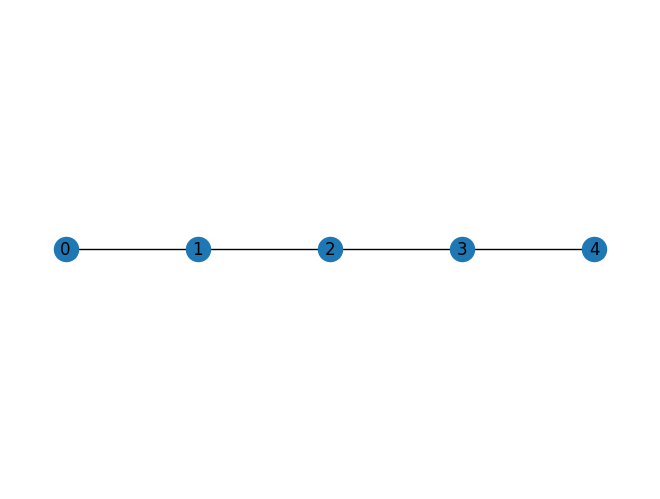

In [20]:
class BaseGraph:
    """Base class for graph generation."""
    
    def __init__(self, N, blockade_radius):
        self.N = N
        self.blockade_radius = blockade_radius
        self.graph = nx.Graph()
        
    def create_graph(self, graph_array):
        """Creates a graph from the given positions."""
        self.add_edges(graph_array)
        
    def add_edges(self, graph_array):
        """Adds edges based on the blockade radius between nodes represented by positions."""
        for v in range(self.N):
            for w in range(v + 1, self.N):
                dist = self.calculate_distance(graph_array[v], graph_array[w])
                if dist <= self.blockade_radius:
                    self.graph.add_edge(v, w)

    def calculate_distance(self, pos1, pos2):
        """Calculates the Euclidean distance between two positions."""
        dist_x = pos1[0] - pos2[0]
        dist_y = pos1[1] - pos2[1]
        return np.sqrt(dist_x**2 + dist_y**2)

    def plot_graph(self):
        """Plots the generated graph."""
        nx.draw(self.graph, with_labels=True, pos=nx.get_node_attributes(self.graph, 'pos'))
        plt.show()


class ChainGraph(BaseGraph):
    """Class for generating a chain graph."""
    
    def __init__(self, N, blockade_radius):
        super().__init__(N, blockade_radius)

    def create_graph(self):
        """Creates a chain graph and adds edges based on blockade radius."""
        graph = [(i * self.blockade_radius, 0) for i in range(self.N)]
        # Store positions in nodes
        for idx, pos in enumerate(graph):
            self.graph.add_node(idx, pos=pos)
        super().create_graph(graph)

# Example usage:
N = 5
blockade_radius = 1.0  # Define your blockade radius here
chain_graph = ChainGraph(N, blockade_radius)
chain_graph.create_graph()
chain_graph.plot_graph()

### Construct the initial hamiltonians

The normal $H_0$ is based on the the existing algorithem:
$$H_0 = \sum_{n=1}^NI - \sigma_x^n$$

And the new $H_0$ is exacly the one described above. 


In [21]:
def initialize_states_and_hamiltonians(params, graph_instance):
    """
    Initializes the Hamiltonians and state vectors based on the graph properties.

    Parameters:
    params (dict): A dictionary of system parameters including DEGREE_MIN and delta.
    graph_instance (BaseGraph): An instance of the graph class (e.g., ChainGraph).
    
    Returns:
    tuple: (hamiltonians, psi_states)
    """
    
    delta = params['delta']
    degree_min = params['DEGREE_MIN']

    # Generate operators
    N = len(graph_instance.graph.nodes)  # Using the number of nodes in the chain graph
    sx_list, sz_list, one_list, I_N = generate_operators(N)

    # Classical Hamiltonian
    CL_H0 = I_N
    for n in range(N):
        CL_H0 -= sx_list[n]

    # Guess Hamiltonian
    GU_H0 = 0
    Hd = 0
    G = graph_instance.graph  # Ensure G is defined from the chain graph
    for n in range(N):
        guess = ((1/G.degree[n]) >= degree_min)
        GU_H0 += guess * I_N + sz_list[n] * (1 - 2 * guess)
        Hd += delta * sx_list[n]

    # State preparation
    guess_psi_list = [one if ((1/G.degree[n]) >= degree_min) else zero for n in range(N)]
    classis_psi_list = [zero for _ in range(N)]
    guess_psi0 = tensor(guess_psi_list)
    classis_psi0 = tensor(classis_psi_list)

    Hp = 0
    H_int = 0

    for v in range(N):
        Hp -= one_list[v] 
        for w in range(v+1, N):
            dist_x = G.nodes[v]['pos'][0] - G.nodes[w]['pos'][0]
            dist_y = G.nodes[v]['pos'][1] - G.nodes[w]['pos'][1]
            dist = np.sqrt(dist_x**2 + dist_y**2)
            H_int += params["INTERACTION_STRENGTH"] / (dist)**6 * one_list[v] * one_list[w]

    ##########################################################
    #### DEFINING EACH hamiltonian and its time function ####
    ##########################################################

    # Store Hamiltonians in a dictionary
    hamiltonians = {
        "classic": [[CL_H0, params['Omega']], [Hp, params['Delta']], H_int],
        "setup": [[params['DELTA_0'] * GU_H0, lambda t: 1 - t / params['TAU_MAX']], 
                  [Hd, params['Omega']], 
                  [params['DELTA_0'] * Hp, lambda t: t / params['TAU_MAX']], H_int],
        "guess": [[GU_H0, params['Omega']], [Hd, params['Omega']], [Hp, params['Delta']], H_int]
    }

    # Store state vectors in a dictionary
    psi_states = {
        "guess": guess_psi0,
        "classical": classis_psi0
    }

    return hamiltonians, psi_states

# Example usage
hamiltonians, psi_states = initialize_states_and_hamiltonians(params, chain_graph)

### Construct evolution Hamiltonian
This code segment initializes and calculates the Hamiltonian for a system of \(N\) Rydberg atoms arranged in a two-dimensional space. 
$$H_{int} = \sum_{v<w}V/x^6(|\vec{x}_v-\vec{x}_w|)n_vn_w$$
$$H_{tot} = H_0 \Omega(t) + H_p\Delta(t) + H_{int}$$

In [22]:
def solve_hamiltonians(hamiltonians, psi_states, params):
    """
    Transforms Hamiltonians to QobjEvo and solves them using the Schrödinger equation.

    Parameters:
    hamiltonians (dict): A dictionary containing Hamiltonians as arrays.
                         Example: hamiltonians["classic"], hamiltonians["guess"], hamiltonians["setup"]
    psi_states (dict): A dictionary containing initial state vectors.
                       Example: psi_states["classical"], psi_states["guess"]
    params (dict): A dictionary of parameters, including 'taulist'.

    Returns:
    tuple: Two dictionaries - one for Hamiltonians and one for results from solving the Hamiltonians.
    """
    
    # Extract parameters
    taulist = params['taulist']

    # Transform Hamiltonians to QobjEvo
    classic_h_t = QobjEvo(hamiltonians["classic"])
    classic_result = sesolve(classic_h_t, psi_states["classical"], taulist, [], {})

    guess_h_t = QobjEvo(hamiltonians["guess"])
    guess_result = sesolve(guess_h_t, psi_states["classical"], taulist, [], {})

    setup_h_t = QobjEvo(hamiltonians["setup"])
    setup_result = sesolve(setup_h_t, psi_states["guess"], taulist, [], {})

    # Return Hamiltonians and results in separate dictionaries
    hamiltonians_out = {
        "classic": classic_h_t,
        "guess": guess_h_t,
        "setup": setup_h_t,
    }

    results_out = {
        "classic": classic_result,
        "guess": guess_result,
        "setup": setup_result,
    }

    return hamiltonians_out, results_out

# Call the function and unpack results
hamiltonians_out, results_out = solve_hamiltonians(hamiltonians, psi_states, params)

## Results analysis

### Minimal gap 

In MIS usually a miniamal gap is not a good indication of complexity since there will be divergence. However in simple chain graphs it can still be an indication.

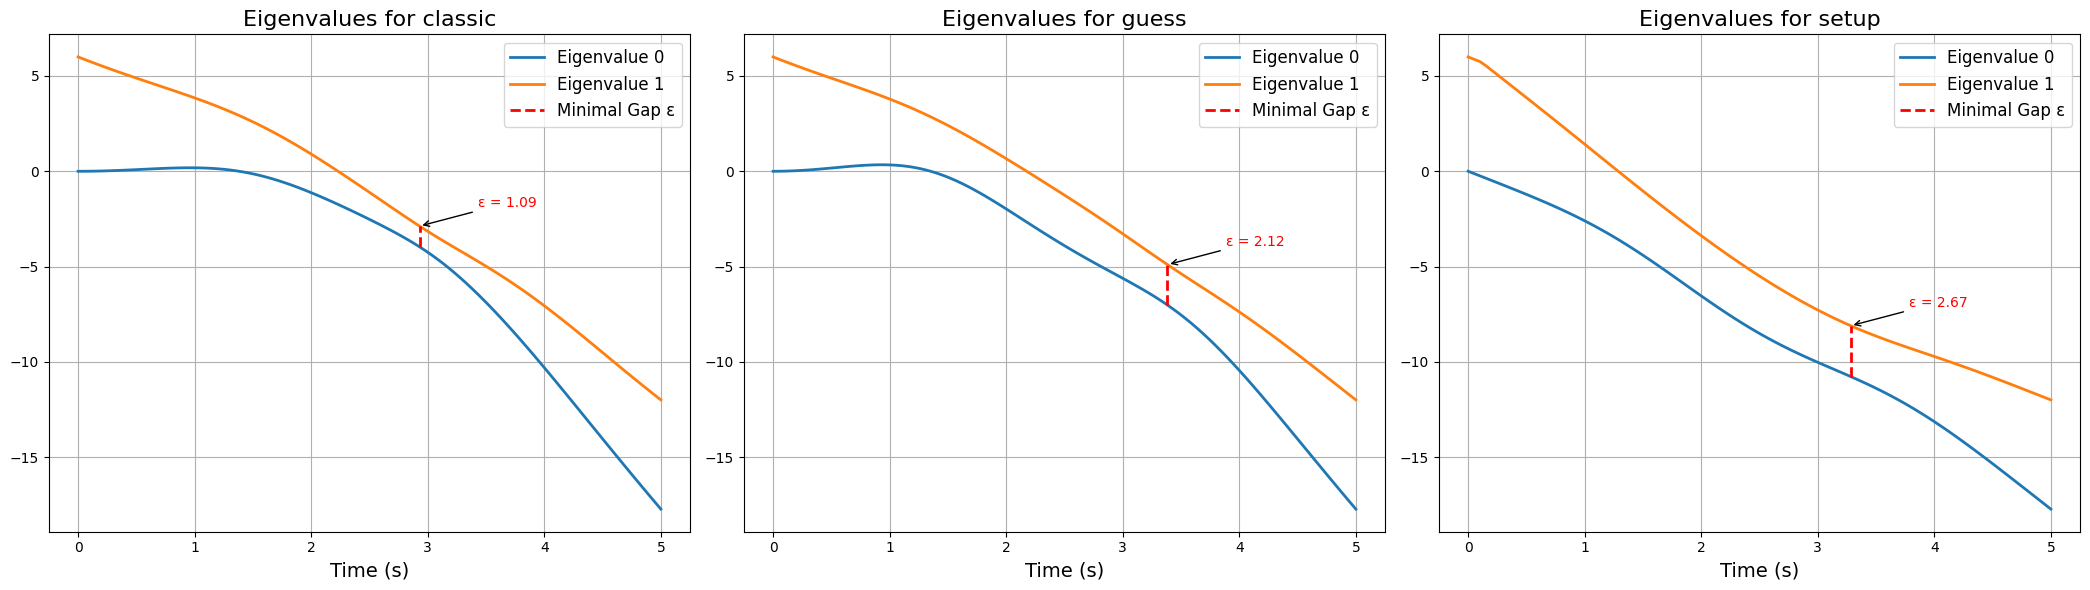

In [23]:
def plot_eigenvalues(taulist, hamiltonians, N, M=2):
    """Plots eigenvalues for the given Hamiltonians over time in a compact format."""
    eigenvalues = {key: np.zeros((len(taulist), 2**N)) for key in hamiltonians.keys()}

    for key in hamiltonians:
        for i, t in enumerate(taulist):
            H = hamiltonians[key](t)
            eigenvalues[key][i, :] = H.eigenenergies()

    fig, axs = plt.subplots(1, 3, figsize=(21, 6))

    for ax, key in zip(axs, hamiltonians.keys()):
        for m in range(M):
            ax.plot(taulist, eigenvalues[key][:, m], label=f"Eigenvalue {m}", linewidth=2)

        lowest_eigenvalues = eigenvalues[key][:, :2]
        gap_values = lowest_eigenvalues[:, 1] - lowest_eigenvalues[:, 0]
        epsilon = np.min(gap_values)
        gap_time_index = np.argmin(gap_values)

        ax.plot([taulist[gap_time_index]] * 2,
                [lowest_eigenvalues[gap_time_index, 0], lowest_eigenvalues[gap_time_index, 1]],
                color='red', linestyle='--', linewidth=2, label='Minimal Gap ε')

        ax.annotate(f'ε = {epsilon:.2f}', 
                     xy=(taulist[gap_time_index], lowest_eigenvalues[gap_time_index, 0] + epsilon),
                     xytext=(taulist[gap_time_index] + 0.5, lowest_eigenvalues[gap_time_index, 0] + epsilon + 1),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=10, color='red')

        ax.set_title(f'Eigenvalues for {key}', fontsize=16)
        ax.set_xlabel('Time (s)', fontsize=14)
        ax.legend(fontsize=12)
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_eigenvalues(taulist, hamiltonians_out,N, M=2)

And clearly Our hamiltonian was the best :)

### States comparing
I gave the sytem a small time frame for the problem. Hence no algorithm is done solving it yet. Using that we can see the difference in how each of them works.

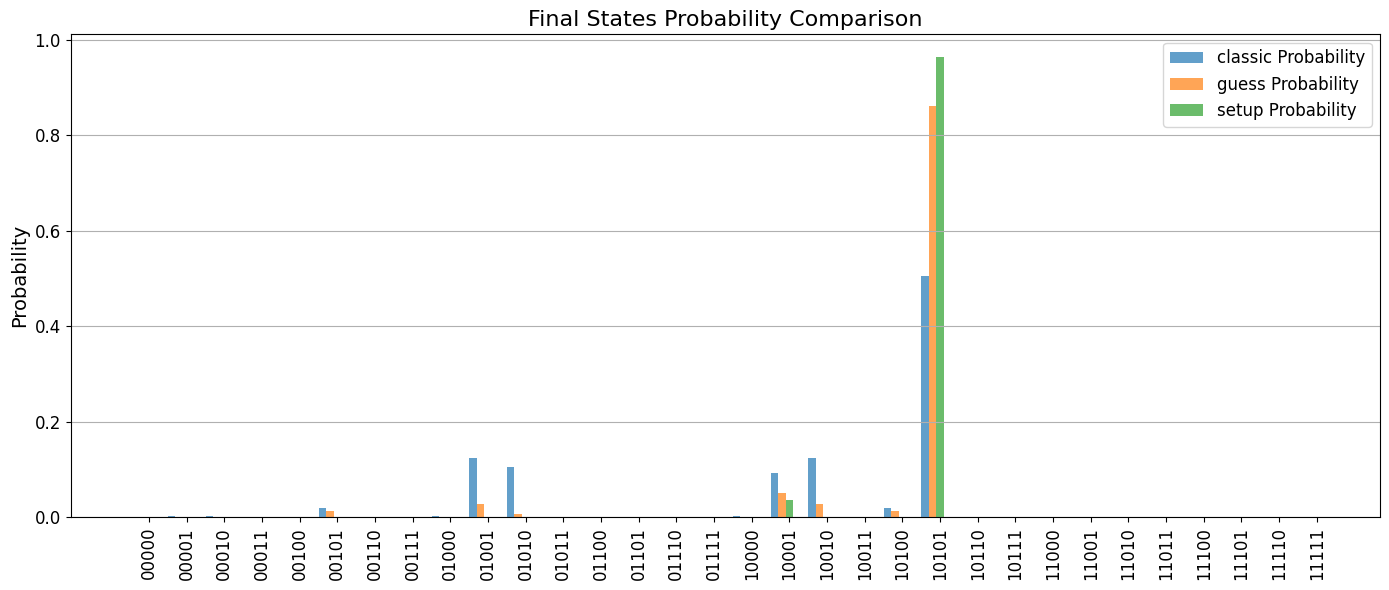

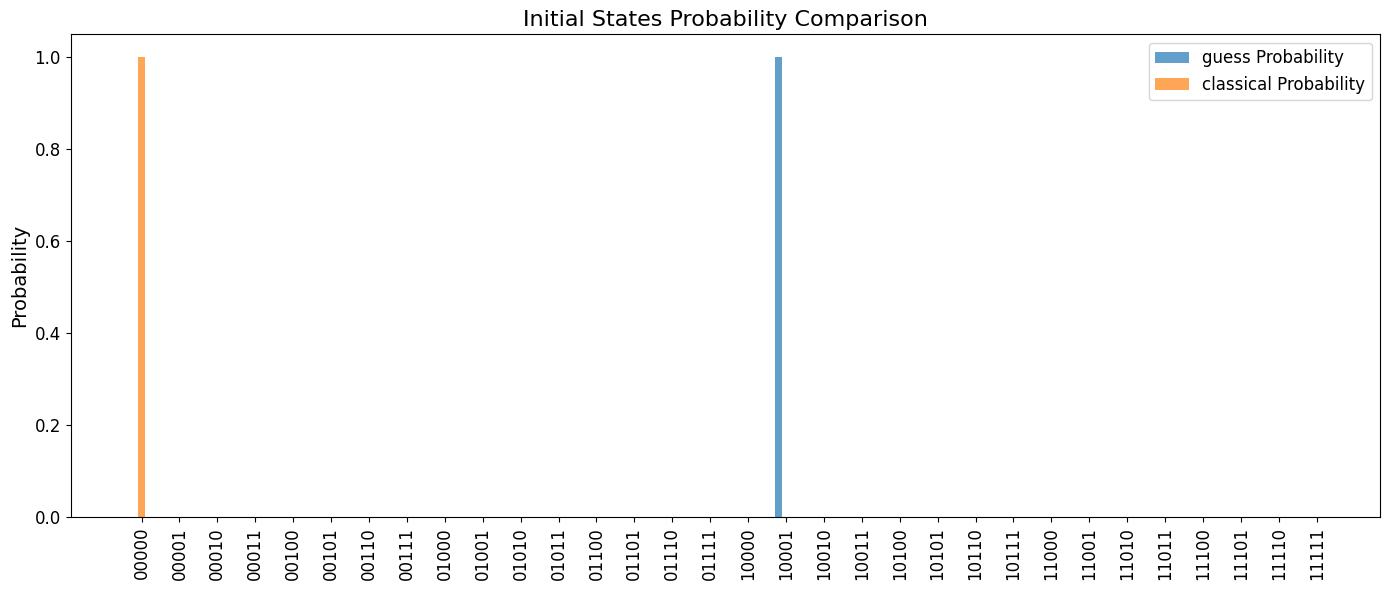

In [24]:
def plot_probabilities(results_out, psi_states, N):
    """
    Plots the initial and final state probabilities for the given results.

    Parameters:
    results_out (dict): Dictionary containing results for the different Hamiltonians.
    psi_states (dict): Dictionary containing initial state vectors.
    N (int): Number of qubits/nodes in the graph.
    """
    # Define the digits and generate all combinations of states
    digits = [0, 1]
    combinations = product(digits, repeat=N)
    lst = [''.join(map(str, combination)) for combination in combinations]

    # Extract coefficients for final states for all results
    coeff_final = {
        key: [np.abs(a_i[0])**2 for a_i in value.states[-1].full()]
        for key, value in results_out.items()
    }

    # Extract coefficients for initial states
    coeff_initial = {
        key: [np.abs(a_i[0])**2 for a_i in psi_states[key].full()]
        for key in psi_states
    }

    # Create x positions for the bars
    x = np.arange(len(lst))  # X positions for the bar graph

    # Plot final states
    plt.figure(figsize=(14, 6))
    for i, (label, coeffs) in enumerate(coeff_final.items()):
        plot_setup(plt.gca(), x + (i - 1) * 0.2, lst, coeffs, label)
    
    plt.title('Final States Probability Comparison', fontsize=16)
    plt.tight_layout()  # Adjust layout
    plt.show()

    # Plot initial states
    plt.figure(figsize=(14, 6))
    for i, (label, coeffs) in enumerate(coeff_initial.items()):
        plot_setup(plt.gca(), x + (i - 0.5) * 0.2, lst, coeffs, label)
    
    plt.title('Initial States Probability Comparison', fontsize=16)
    plt.tight_layout()  # Adjust layout
    plt.show()

# Call the function with the appropriate parameters
plot_probabilities(results_out, psi_states, N)


---
# final points 

Clearly in simple cases we can see our solution helps. And as I think I proved above our guess is never wrong so it is very likely to help (even though it can create divergence). As a follow up we need to use another system instead of minimal gaps which will allow us to check a collection of graphs instead of testing them in an anecdotal way. 

In addition, the constants for the new hamiltonians were not optimized. Specificly the usage of $\delta$ and $\Delta_0$ in the final hamiltonian was a guess and is assumed to be improvable.